<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/ffjord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install flax

     |████████████████████████████████| 184kB 3.0MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 


In [ ]:
from functools import partial
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad,jacfwd,jit,value_and_grad
from jax import random
from jax.experimental.ode import odeint
from jax.scipy.stats.multivariate_normal import logpdf

In [ ]:
import flax.linen as nn
import optax

## Data

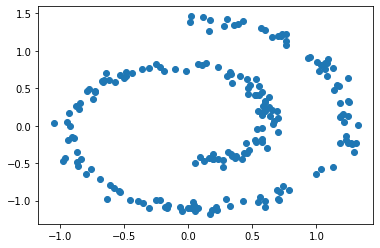

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons,make_swiss_roll

#data, _ = make_moons(200, noise=0.1, random_state=0)
#plt.scatter(data[:, 0], data[:, 1])

data, _= make_swiss_roll(200, noise=0.5)
data = data[:, [0, 2]] / 10.0
plt.scatter(data[:, 0], data[:, 1])

## Define Net

In [ ]:
class Net(nn.Module):
    @nn.compact
    def __call__(self,x,t):
        t = jnp.expand_dims(t,0)
        x = jnp.concatenate((x,t))
        x = nn.Dense(100)(x)
        x = nn.softplus(x)
        x = jnp.concatenate((x,t))
        x = nn.Dense(100)(x)
        x = nn.softplus(x)
        x = jnp.concatenate((x,t))
        x = nn.Dense(100)(x)
        x = nn.softplus(x)
        x = jnp.concatenate((x,t))
        x = nn.Dense(2)(x)
        return x

In [ ]:
net = Net()

## Define ODE function

In [ ]:
def ODEfunc(x,t,param):
    z,_ = x
    z_dot = net.apply(param,z,t)
    
    jacobian = jax.jacfwd(net.apply,argnums=1)
    jac = jacobian(param,z,t)
    trace_jac = jnp.trace(jac)
    return z_dot,-trace_jac

### use vmap to make vectorize function 

In [ ]:
vec_ODEfunc = jax.vmap(ODEfunc,(0,None,None))

## Compute log probability

In [ ]:
def loss(param,data):
    z, delta_logpz = odeint(vec_ODEfunc,
                            (data,np.zeros(data.shape[0])),
                            np.array([0.,1.]),
                            param)
    logpz_t0 = logpdf(z[-1], np.zeros(2), np.eye(2))
    logpz_t1 = logpz_t0 - delta_logpz
    loss = -logpz_t1.mean()
    return loss

## Training

In [ ]:
key, init_key = random.split(random.PRNGKey(0))
param = net.init(init_key,
                 np.random.rand(2),
                 0.)

In [ ]:
opt = optax.adam(1e-3)
opt_state = opt.init(param)

In [ ]:
@jax.jit
def train_step(param,data,opt_state):
    loss_value, grads = value_and_grad(loss)(param,data)
    updates, opt_state = opt.update(grads, opt_state)
    param = optax.apply_updates(param, updates)
    return loss_value, param, opt_state

In [ ]:
%timeit train_step(param,data,opt_state)

The slowest run took 508.80 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 26.5 ms per loop


In [ ]:
for _ in range(5000):
    loss_value, param, opt_state = train_step(param,data,opt_state)
    #print(loss_value)

## Sampling

In [ ]:
def reverse_ODEfunc(x,t,param):
    t = -t
    z_dot = net.apply(param,x,t)
    return -z_dot

In [ ]:
vec_reverse_ODEfunc = jax.vmap(reverse_ODEfunc,(0,None,None))

In [ ]:
init = np.random.multivariate_normal(np.zeros(2),np.eye(2),size=(200,))

In [ ]:
z = odeint(vec_reverse_ODEfunc,
           init,
           np.linspace(-1,0,50),
           param)

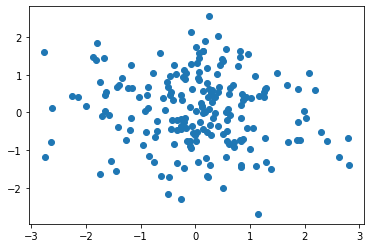

In [ ]:
plt.scatter(z[0,:,0],z[0,:,1])

### make gif

In [ ]:
%mkdir ./gif
f_ = []
for i in range(z.shape[0]):
    plt.scatter(z[i,:,0],z[i,:,1])
    f = './gif/{i}.png'.format(i=i)
    f_.append(f)
    plt.savefig(f)
    plt.close()

mkdir: cannot create directory ‘./gif’: File exists


In [ ]:
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for f in f_:
        image = imageio.imread(f)
        writer.append_data(image)
    for _ in range(10):
        writer.append_data(image)

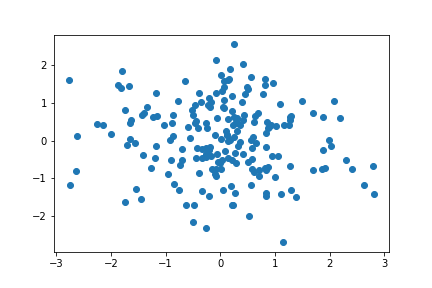

In [ ]:
Image(open('mygif.gif','rb').read())